In [1]:
# Time Series Models – Prophet & SARIMA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load cleaned dataset
df = pd.read_csv(r"C:\Hyn\Tourist-Flow-And-Seasonality-Analyzer-With-Event-Impact\Tourist-Flow-And-Seasonality-Analyzer-With-Event-Impact\data\cleaned\all_parks_recreation_visits.csv")


In [3]:
print(df.shape)
df.head()

(88869, 8)


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits
0,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,1,0.0
1,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,2,0.0
2,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,3,0.0
3,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,4,965.0
4,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,5,2428.0


In [4]:
# Normalize column names
df.columns = [c.lower().replace(" ", "_") for c in df.columns]

In [5]:
# Filter relevant columns
df = df[["park", "state", "year", "month", "recreation_visits"]]

In [6]:
# Combine year+month into a proper datetime
df["date"] = pd.to_datetime(df["year"].astype(int).astype(str) + "-" + df["month"].astype(int).astype(str) + "-01")

In [7]:
# Aggregate by month for total US visits (you can later do this per park/state)
monthly = df.groupby("date", as_index=False)["recreation_visits"].sum()

monthly = monthly.sort_values("date")
monthly.tail()

,date,recreation_visits
547,2024-08-01,20117321.0
548,2024-09-01,17004950.0
549,2024-10-01,14689987.0
550,2024-11-01,10715032.0
551,2024-12-01,9172285.0


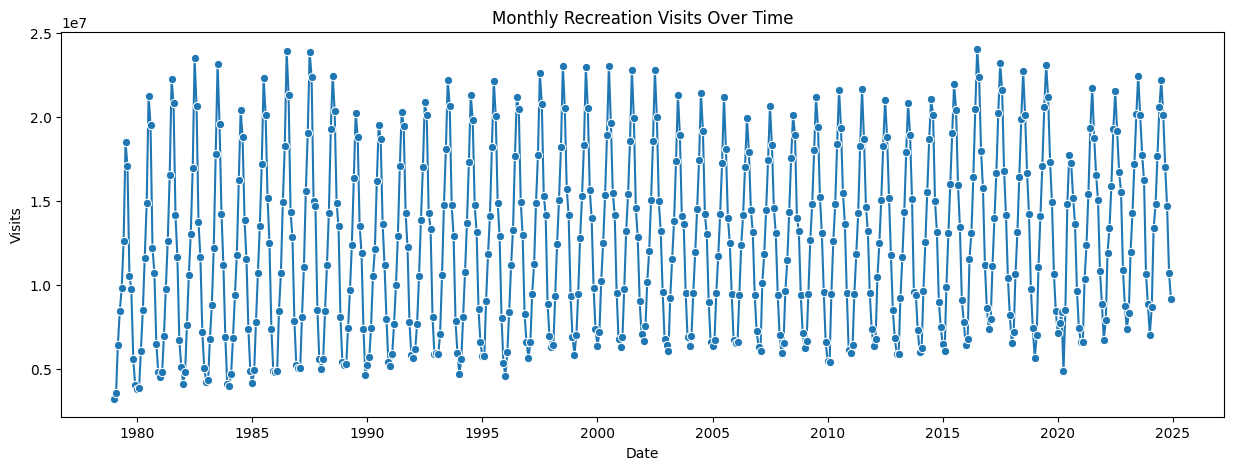

In [8]:
# Visualize the Time Series
plt.figure(figsize=(15,5))
sns.lineplot(data=monthly, x="date", y="recreation_visits", marker="o")
plt.title("Monthly Recreation Visits Over Time")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.show()

In [9]:
# Split Data (Train/Test)
train = monthly.iloc[:-12]
test = monthly.iloc[-12:]

print("Train range:", train["date"].min(), "to", train["date"].max())
print("Test range:", test["date"].min(), "to", test["date"].max())

Train range: 1979-01-01 00:00:00 to 2023-12-01 00:00:00
Test range: 2024-01-01 00:00:00 to 2024-12-01 00:00:00


In [10]:
# MODEL 1: Facebook Prophet
# Prophet expects columns as 'ds' and 'y'
prophet_df = train.rename(columns={"date": "ds", "recreation_visits": "y"})

In [11]:
# Initialize and fit model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(prophet_df)

19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Make future dataframe
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
forecast = prophet_model.predict(future)

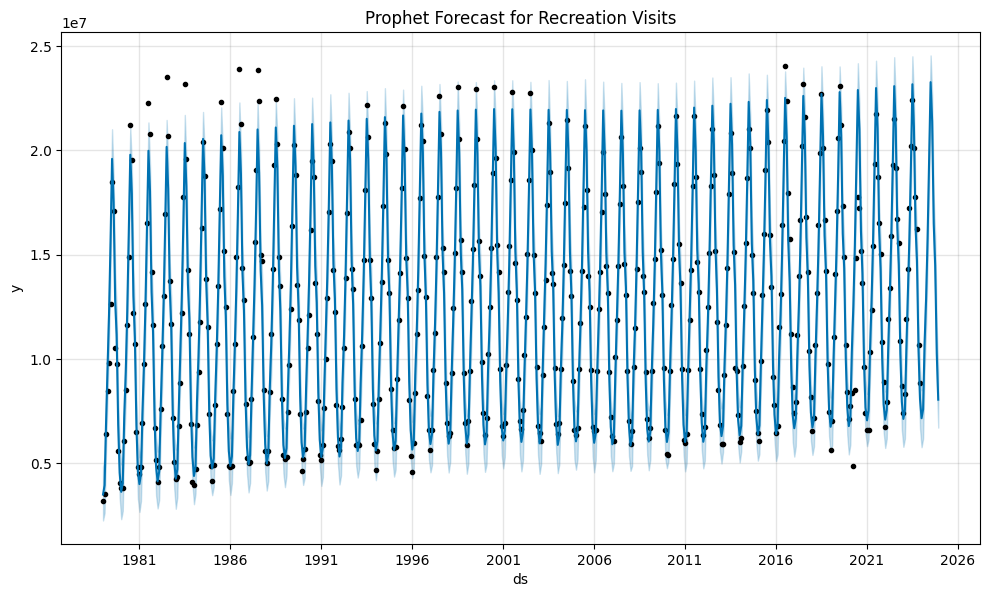

In [13]:
# Plot forecast
prophet_model.plot(forecast)
plt.title("Prophet Forecast for Recreation Visits")
plt.show()

In [14]:
# Compare forecast vs actual
pred = forecast.set_index("ds").loc[test["date"], "yhat"]
test = test.set_index("date")
test["Prophet_Pred"] = pred

In [15]:
# Metrics
mae = mean_absolute_error(test["recreation_visits"], test["Prophet_Pred"])
rmse = np.sqrt(mean_squared_error(test["recreation_visits"], test["Prophet_Pred"]))

print(f"Prophet → MAE: {mae:,.0f} | RMSE: {rmse:,.0f}")

Prophet → MAE: 1,118,848 | RMSE: 1,334,188


In [16]:
# MODEL 2: SARIMA (Seasonal ARIMA)
# Define and fit SARIMA
sarima_model = SARIMAX(train["recreation_visits"], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

In [17]:
# Forecast
sarima_pred = sarima_fit.forecast(steps=12)
test["SARIMA_Pred"] = sarima_pred.values

In [18]:
# Metrics
mae_sarima = mean_absolute_error(test["recreation_visits"], test["SARIMA_Pred"])
rmse_sarima = np.sqrt(mean_squared_error(test["recreation_visits"], test["SARIMA_Pred"]))

print(f"SARIMA → MAE: {mae_sarima:,.0f} | RMSE: {rmse_sarima:,.0f}")

SARIMA → MAE: 648,529 | RMSE: 761,041


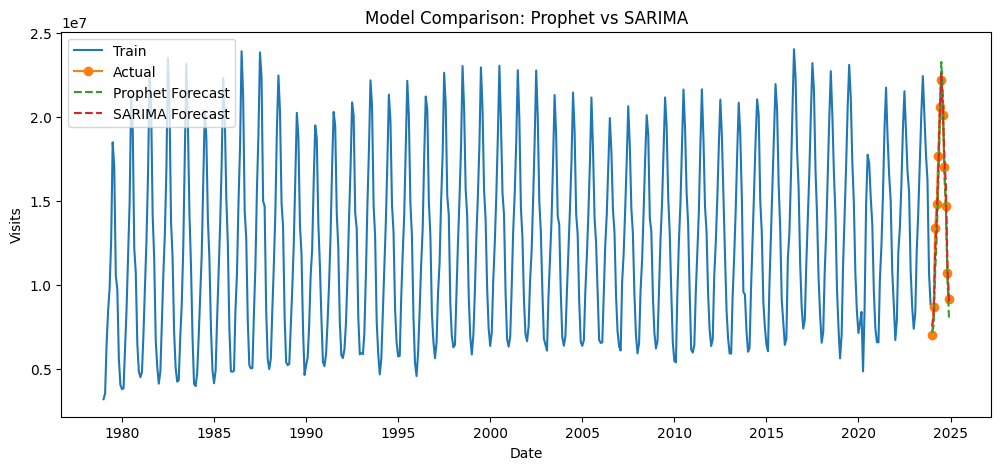

In [19]:
# Plot comparison
plt.figure(figsize=(12,5))
plt.plot(train["date"], train["recreation_visits"], label="Train")
plt.plot(test.index, test["recreation_visits"], label="Actual", marker="o")
plt.plot(test.index, test["Prophet_Pred"], label="Prophet Forecast", linestyle="--")
plt.plot(test.index, test["SARIMA_Pred"], label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.title("Model Comparison: Prophet vs SARIMA")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.show()

In [20]:
results = pd.DataFrame({
    "Model": ["Prophet", "SARIMA"],
    "MAE": [mae, mae_sarima],
    "RMSE": [rmse, rmse_sarima]
})
results["Best"] = results["RMSE"] == results["RMSE"].min()
results

,Model,MAE,RMSE,Best
0,Prophet,1.118848e+06,1.334188e+06,False
1,SARIMA,6.485286e+05,7.610409e+05,True


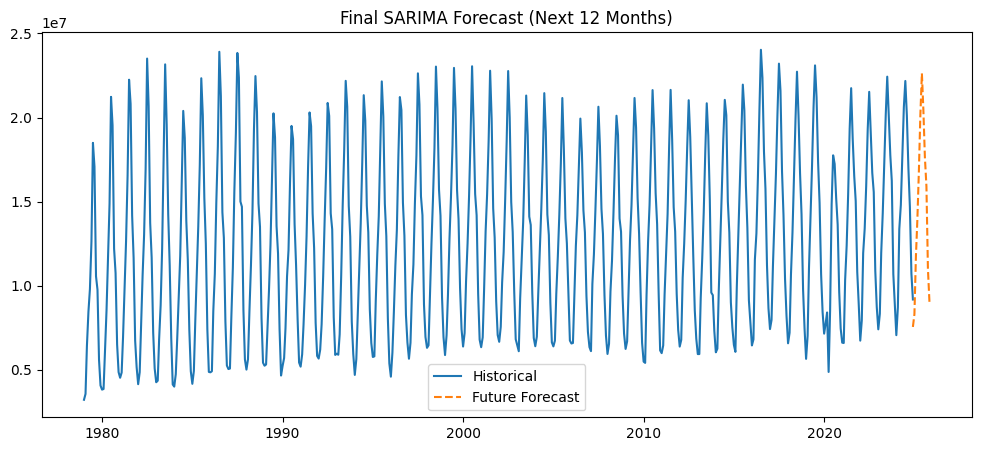

In [21]:
future_forecast = sarima_fit.forecast(steps=12)
plt.figure(figsize=(12,5))
plt.plot(monthly["date"], monthly["recreation_visits"], label="Historical")
plt.plot(pd.date_range(monthly["date"].iloc[-1], periods=12, freq='MS'), future_forecast, label="Future Forecast", linestyle="--")
plt.legend()
plt.title("Final SARIMA Forecast (Next 12 Months)")
plt.show()

In [22]:
# Comparison DataFrame (from your previous code)
results = pd.DataFrame([
    {"Model": "Prophet", "MAE": float(mae),        "RMSE": float(rmse)},
    {"Model": "SARIMA",  "MAE": float(mae_sarima), "RMSE": float(rmse_sarima)},
])

# Pick best = lowest RMSE, tie-break by MAE
best_idx = results.sort_values(["RMSE", "MAE"], ascending=True).index[0]
results["Best"] = False
results.loc[best_idx, "Best"] = True

# --- Styling fix for VS Code dark mode ---
def highlight_best(row):
    if row.get("Best", False):
        return [
            "background-color: #00b894; color: black; font-weight: bold;"  # bright teal for dark mode
        ] * len(row)
    else:
        return [""] * len(row)

styler = (
    results.style
    .format({"MAE": "{:,.0f}", "RMSE": "{:,.0f}"})
    .apply(highlight_best, axis=1)
)

# hide index safely across pandas versions
try:
    styler = styler.hide(axis="index")
except Exception:
    try:
        styler = styler.hide_index()
    except Exception:
        pass

display(styler)

best_model = results.loc[best_idx, "Model"]
print(f"\n✅ Best model: {best_model} (lowest RMSE; MAE as tiebreaker)")


Model,MAE,RMSE,Best
Prophet,"1,118,848","1,334,188",False
SARIMA,"648,529","761,041",True



✅ Best model: SARIMA (lowest RMSE; MAE as tiebreaker)
